<a href="https://colab.research.google.com/github/Francescolv99/Deep-Video-Deblurring/blob/main/Deep_Video_Deblurring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ottengo il dataset scaricandolo dal link in questione


In [ ]:
!wget http://www.cs.ubc.ca/labs/imager/tr/2017/DeepVideoDeblurring/DeepVideoDeblurring_Dataset.zip
!unzip /content/DeepVideoDeblurring_Dataset.zip

Importo i pacchetti necessari

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from PIL import Image
import pandas as pd
import os

Creo le variabili x e y e le funzioni necessarie per lavorare il dataset

In [2]:
#dim immagini 720x1280x3
x = []
y = []

def appendImmagine(filename, x):
    im_1 = Image.open(filename)
    ar = np.array(im_1)
    ar = ar[300:452,600:800]
    x.append(ar)
    return x
    
#accedo ad ogni immagine nel database e le inserisco in forma matriciale in x e y
def ottieniImmagini(filename, x , y):
    #apro la cartella del dataset
    entries = os.listdir(filename)
    #entries.pop(0)
    #apro ogni sottocartella
    print("LOADING DATASET:")
    for cartella in entries:
      #cartella è per esempio 720p_240fps_1
        #print(cartella)
        if(cartella==".DS_Store" or cartella=="IMG_0051" or cartella=="IMG_0053" or cartella=="IMG_0049"):
              continue
        x, y = ottieniImmaginiCartella(filename + '/' + cartella,x,y)
    x = np.array(x)
    y = np.array(y)
    return x, y

def ottieniImmaginiCartella(filename,x, y):
    #apro la cartella del dataset
    entries = os.listdir(filename)
    #entries.pop(0)
    #apro ogni sottocartella
    for cartella in entries:
        if(cartella=="input"):
            lista_immagini = os.listdir(filename + '/' + cartella)
            a = 0
            for immagine in lista_immagini:
                if a==25:
                    break
                if(immagine==".DS_Store"): 
                    continue
                x = appendImmagine(filename + '/' + cartella + '/' + immagine, x)
                a+=1
        elif(cartella==".DS_Store"):
          continue
        else:
            lista_immagini = os.listdir(filename + '/' + cartella)
            b = 0
            for immagine in lista_immagini:
                if b==25:
                    break
                if(immagine==".DS_Store"): 
                    continue
                y = appendImmagine(filename + '/' + cartella + '/' + immagine, y)
                b+=1
    return x, y

In [3]:
x, y = ottieniImmagini('/content/DeepVideoDeblurring_Dataset/quantitative_datasets', x , y)

LOADING DATASET:


In [4]:
print(np.shape(x),np.shape(y))

(1700, 152, 200, 3) (1700, 152, 200, 3)


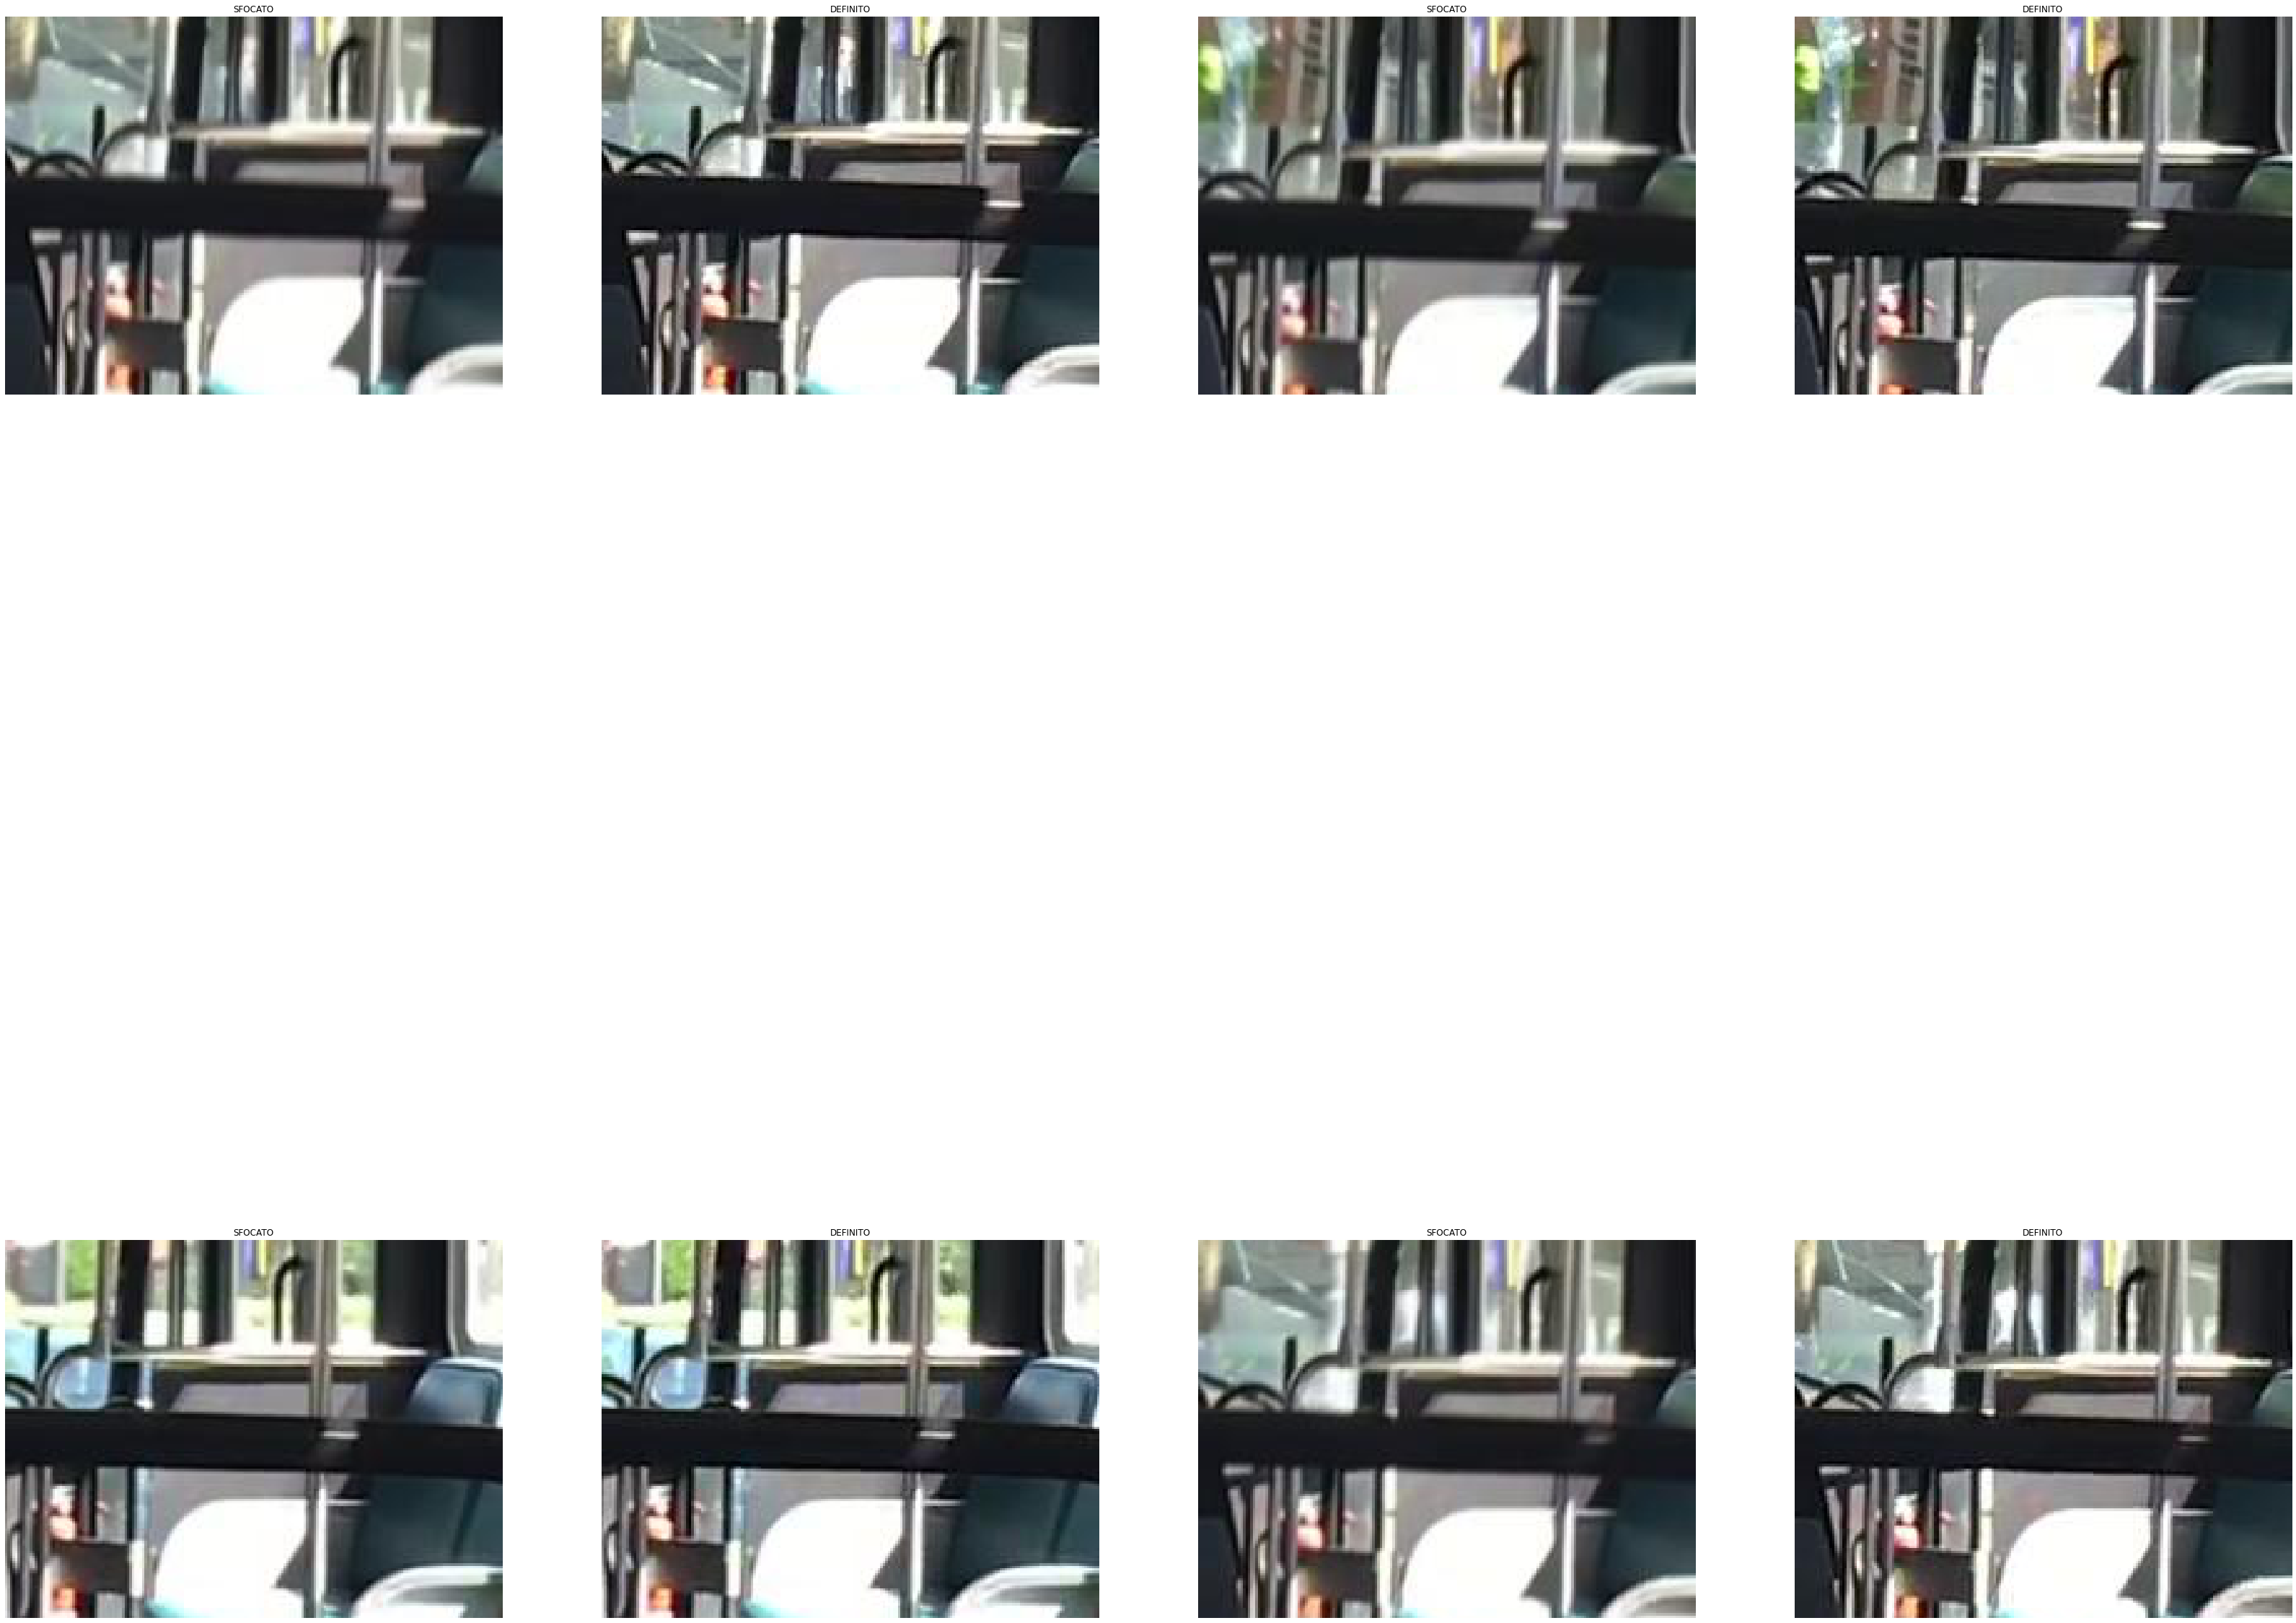

In [5]:
#cerca un modo per stampare meglio queste immagini

import matplotlib.pyplot as plt

n_rows = 2
n_cols = 2


plt.figure(figsize=(n_cols * 28.4, n_rows * 28.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = 2*(n_cols * row + col)
        plt.subplot(n_rows, 2*n_cols, index + 1)
        plt.title("SFOCATO")
        plt.imshow(x[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.subplot(n_rows, 2*n_cols, index + 2)
        plt.title("DEFINITO")
        plt.imshow(y[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        #ingrandire titolo e migliorare stampa immagini
        
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)
#normaliziamo l'input tra 0 e 1
del x
del y

x_train = x_train/255
x_test = x_test/255
y_train = y_train/255
y_test = y_test/255

print(np.shape(x_train))
print(np.max(x_train), np.min(y_train))




(1360, 152, 200, 3)
1.0 0.0


In [7]:
print(np.shape(x_train)[1:])

(152, 200, 3)


In [8]:
#definiamo il nostro modello
input_shape = np.shape(x_train)[1:]

model = keras.models.Sequential([
    #encoder
    keras.layers.Conv2D(filters=32, kernel_size=[3,3], padding="valid", activation="relu", input_shape=input_shape),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(filters=16, kernel_size=[2,2], activation='relu'),
    keras.layers.MaxPool2D(pool_size=[2,2]),
    #decoder
    keras.layers.Conv2DTranspose(32, (2, 2), strides=2, activation="relu", output_padding=1),
    keras.layers.Conv2DTranspose(3, (3, 3), strides=2, activation="relu", output_padding=1),
    #keras.layers.Conv2D(3, (3, 3), activation="sigmoid", padding="valid")
    #keras.layers.Dense(10, activation="softmax")
  ])
model.compile(loss="mse",
              optimizer='adam',
              metrics=["mse"]) #mse anzichè accuracy
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 98, 16)        2064      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 49, 16)       0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 75, 99, 32)       2080      
 nspose)                                                         
                                                        

In [9]:
# train the model
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=50,
    batch_size=128,
    verbose = 1,
    #shuffle=True,
    validation_data=(x_test, y_test),
)


Epoch 1/50
11/11 [==============================] - 12s 276ms/step - loss: 0.1790 - mse: 0.1790 - val_loss: 0.1459 - val_mse: 0.1459
Epoch 2/50
11/11 [==============================] - 2s 139ms/step - loss: 0.1088 - mse: 0.1088 - val_loss: 0.0871 - val_mse: 0.0871
Epoch 3/50
11/11 [==============================] - 2s 140ms/step - loss: 0.0685 - mse: 0.0685 - val_loss: 0.0533 - val_mse: 0.0533
Epoch 4/50
11/11 [==============================] - 2s 140ms/step - loss: 0.0447 - mse: 0.0447 - val_loss: 0.0379 - val_mse: 0.0379
Epoch 5/50
11/11 [==============================] - 2s 139ms/step - loss: 0.0332 - mse: 0.0332 - val_loss: 0.0300 - val_mse: 0.0300
Epoch 6/50
11/11 [==============================] - 2s 139ms/step - loss: 0.0260 - mse: 0.0260 - val_loss: 0.0232 - val_mse: 0.0232
Epoch 7/50
11/11 [==============================] - 2s 139ms/step - loss: 0.0212 - mse: 0.0212 - val_loss: 0.0203 - val_mse: 0.0203
Epoch 8/50
11/11 [==============================] - 1s 137ms/step - loss: 0

11/11 - 0s - loss: 0.0081 - mse: 0.0081 - 483ms/epoch - 44ms/step
mse: 0.81%


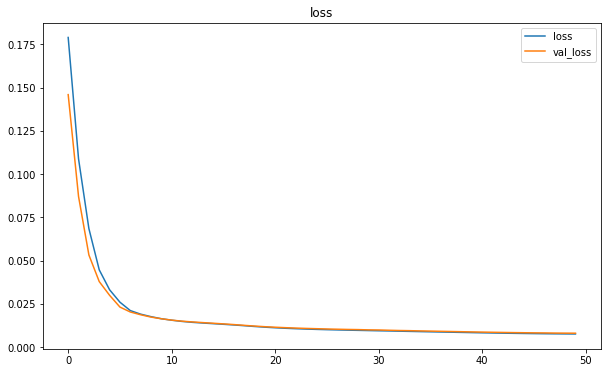

In [10]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'], label='loss')
  plt.plot(history.epoch,history.history['val_loss'],label='val_loss')
  plt.title('loss')
  plt.legend()
def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'],label='accuracy')
  plt.plot(history.epoch,history.history['val_accuracy'],label='val_accuracy')
  plt.title('accuracy')
  plt.legend()

plot_loss(history)

#plot_accuracy(history)

scores = model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [ ]:
# mostrarere di nuovo le immagini correte dalla mia rete neurale rispetto a quelle vere